In [1]:
#  take a set of pmid-clusters and build word2vec models for each

#     sample 1    cluster a, b, c, d

# todo think about how to do statistics on these  (using the other samples perhaps?)

In [15]:
import matplotlib as mpl

import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import igraph
import cairocffi as cairo

import networkx as nx


import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA

import time
import hdbscan

import spacy
from gensim.models import Word2Vec

import random
import re
from pmids2vec import pmids2vec
from pmids2corpus import pmids2corpus



#import cairocffi
#cairocffi.install_as_pycairo()
#import cairo
#assert cairo is cairocffi
import umap

In [2]:
# get abstract-level statistics for idf 
#  warning - need to run the cell below this one first

from collections import defaultdict
import math

doc_freqs = []

for model_path in model_names:
    
    print(model_path)
    
    with open(model_path,'r') as f:
        corpus = json.load(f)   
    
    d_df = defaultdict(int)
    total_abstracts = 0
    for i_abstract, abstract_ in enumerate(corpus):
    
        total_abstracts += 1
        abstract = list(set(abstract_).intersection(set(common_vocabulary)))
        for word in abstract:
            d_df[word] += 1 
            
    for k,v in d_df.items():
        d_df[k] = 1.0*v / total_abstracts
    d_df = dict(sorted(d_df.items(), key=lambda x: x[1], reverse=True))
    
    print(d_df)
    doc_freqs.append(d_df)

    

NameError: name 'model_names' is not defined

In [17]:
# load in the models that were just created


# temp, recreate the list of file names without re-training the w2v models
model_names = ['data_processing/cluster0.model',
        'data_processing/cluster1.model',
        'data_processing/cluster2.model']
print(model_names)
print()

models = {}
for model_name in model_names:
    
    short_name = str.split(model_name,'/')[-1]
    print(short_name)
    
    model = Word2Vec.load(model_name)
    models[short_name] = model
    print('{} words '.format(len(model.wv.vocab)))
    print()
    

['data_processing/cluster0.model', 'data_processing/cluster1.model', 'data_processing/cluster2.model']

cluster0.model
9738 words 

cluster1.model
5275 words 

cluster2.model
10261 words 



In [18]:
# visualize the models

full_vocabulary = []
common_vocabulary = []

for name, model in models.items():
    
    this_vocabulary = [word for word in model.wv.vocab.keys()]
    
    full_vocabulary.extend(this_vocabulary)
    
    if common_vocabulary: # check that the list has been initialized
        common_vocabulary = list( set(common_vocabulary).intersection(set(this_vocabulary)) )
    else:
        common_vocabulary = this_vocabulary  # first loop
    
full_vocabulary = list(set(full_vocabulary))  # get unique strings

print("length of full vocabulary: {} ".format(len(full_vocabulary)))
print("length of common vocabulary: {} ".format(len(common_vocabulary)))

#common_vocabulary = common_vocabulary[100:150] # temp

length of full vocabulary: 15811 
length of common vocabulary: 2988 


In [19]:
print(mpl.get_backend())

module://ipykernel.pylab.backend_inline


(2988, 2988)
(2988, 2988)
(2988, 2988)


"\nG_igraph_total = igraph.Graph.Weighted_Adjacency(W_total.tolist(),\n                                               mode=igraph.ADJ_UNDIRECTED,\n                                              loops=False,\n                                              attr='weight')\n"

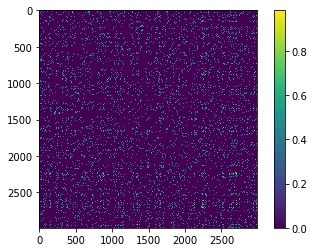

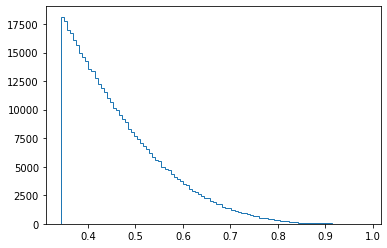

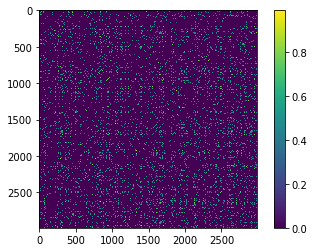

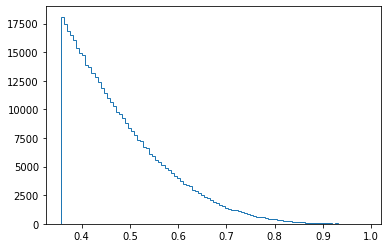

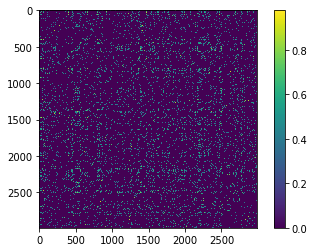

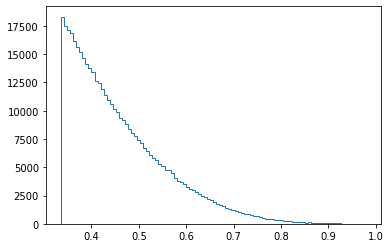

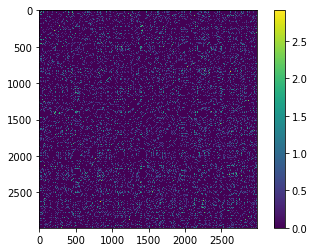

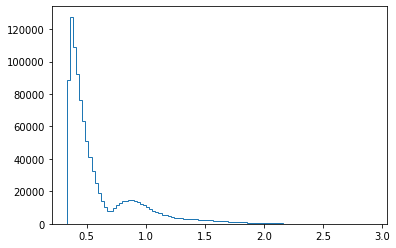

In [35]:
# build adjacency matrix for common network

#igraphs = []
nx_graphs = []
W_total = np.zeros((len(common_vocabulary), len(common_vocabulary)))  # for layout purposes
for idx, model in enumerate(models.values()):
    
    # the number of nodes is small so we can do this with mat mul
    D = np.shape(model.wv[common_vocabulary[0]])[0]
    embedding_samples = np.zeros( (len(common_vocabulary), D) )
    
    for i_word, word in enumerate(common_vocabulary):
        embedding_samples[i_word,:] = model.wv[word]
        
    # reduce dimensionality
    #D_umap = 5
    #reducer = umap.UMAP(n_components=D_umap)
    #um = reducer.fit_transform(embedding_samples)    # concatenated
    #embedding_samples = um
    
    # demean
    for i_word, word in enumerate(common_vocabulary):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
    
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
        
    # compute cosine similarity (projection of normalized vectors)
    W = np.matmul(embedding_samples, embedding_samples.T)
    np.fill_diagonal(W, 0)  # no self-loops
    thresh_low = np.percentile(W.flatten(), 5)
    thresh_high = np.percentile(W.flatten(), 90) # 90
    #boolean_mask = np.logical_and(W < thresh_high, W > thresh_low)
    boolean_mask = W < thresh_high
    #boolean_mask = W > thresh_low
    W[boolean_mask] = 0 # mask out some weights for testing
    #W[W.nonzero()] = -1 * W[W.nonzero()]  # temp - for running cuthill mckee on negative weights
    W_total += W
    print(np.shape(W))

    plt.figure()
    plt.imshow(W)
    plt.colorbar()
    
    plt.figure()
    plt.hist(np.tril(W,k=-1)[np.tril(W,k=-1).nonzero()].flatten(),histtype='step', bins=100)
    
    # create igraph verion
    '''
    G_igraph = igraph.Graph.Weighted_Adjacency(W.tolist(),
                                               mode=igraph.ADJ_UNDIRECTED,
                                              loops=False,
                                              attr='weight')
    igraphs.append(G_igraph)
    '''
    
    
    # create networkx version
    G_nx = nx.from_numpy_matrix(W)  # create using - 
    nx.set_node_attributes(G_nx,
                           dict((i,w) for i,w in enumerate(common_vocabulary)),
                           'word')
    #doc_freq = [doc_freqs[idx][word] for word in common_vocabulary]
    #nx.set_node_attributes(G_nx, doc_freq, 'doc_freq')
    d_triangles = nx.triangles(G_nx)
    nx.set_node_attributes(G_nx, d_triangles, 'triangles')
    d_eigcent = nx.eigenvector_centrality(G_nx)
    nx.set_node_attributes(G_nx, d_eigcent, 'eigenvector_centrality')
    nx_graphs.append(G_nx)
    
plt.figure()
plt.imshow(W_total)
plt.colorbar()

plt.figure()
plt.hist(np.tril(W_total,k=-1)[np.tril(W_total,k=-1).nonzero()].flatten(),histtype='step', bins=100)

'''
G_igraph_total = igraph.Graph.Weighted_Adjacency(W_total.tolist(),
                                               mode=igraph.ADJ_UNDIRECTED,
                                              loops=False,
                                              attr='weight')
'''

computing num triangles...
fetching adjmat...
computing num triangles...
fetching adjmat...
computing num triangles...
fetching adjmat...


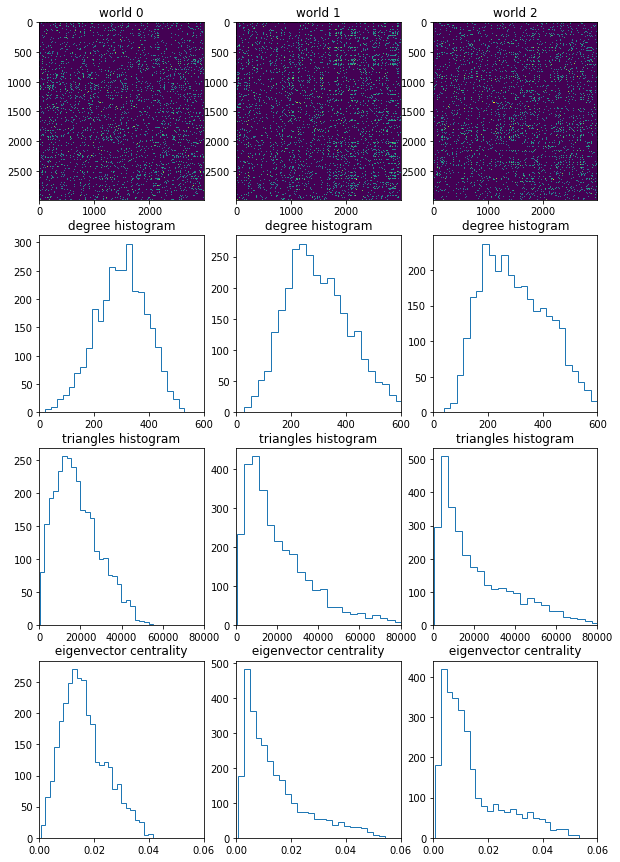

In [36]:
# plot the adjmats

(f, ax) = plt.subplots(4,
                       3,
                       figsize=(10,15))

community_results = []
for idx, G in enumerate(nx_graphs):
    
    print('computing num triangles...')
    #communities = nx.algorithms.community.label_propagation_communities(G)
    #community_results.append([x for x in communities])
    
    
    
    
    print('fetching adjmat...')
    W = nx.convert_matrix.to_numpy_matrix(G)
    degrees = [d for n,d in G.degree()]
    
    ax[0,idx].imshow(W,aspect='auto')
    ax[0,idx].set_title('world {}'.format(idx))
    
    #ax[1,idx].set_ylim(bottom=0)
    ax[1,idx].hist(degrees, bins=25, histtype='step')
    ax[1,idx].set_title('degree histogram')
    ax[1,idx].set_xlim([0,600])
    
    d_triangles = nx.get_node_attributes(G,'triangles')
    ax[2,idx].hist([count for count in d_triangles.values()], bins=25, histtype='step')
    ax[2,idx].set_title('triangles histogram')
    ax[2,idx].set_xlim([0,80000])
    
    d_eigcent = nx.get_node_attributes(G, 'eigenvector_centrality')
    ax[3,idx].hist([count for count in d_eigcent.values()], bins=25, histtype='step')
    ax[3,idx].set_title(' eigenvector centrality ')
    ax[3,idx].set_xlim([0,0.06])
    
plt.savefig('network_worlds_overview.pdf')
plt.savefig('network_worlds_overview.png')

computing cuthull mckee ordering...
finished.
computing cuthull mckee ordering...
finished.
computing cuthull mckee ordering...
finished.


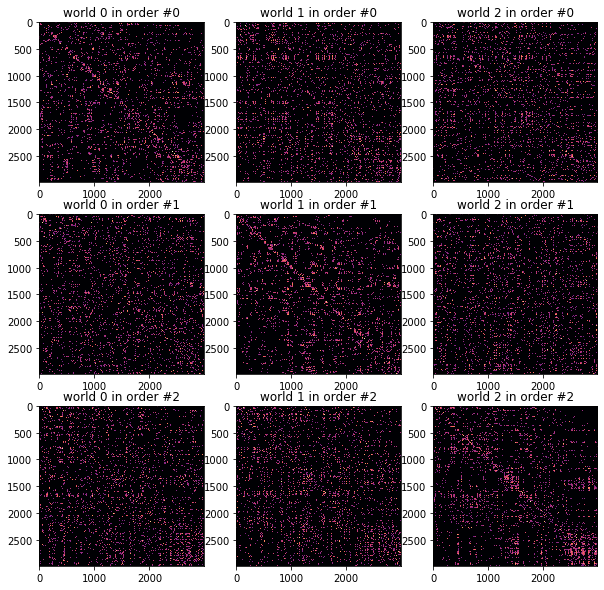

In [22]:
# plot each adjmat in cuthill-mckee order


(f, ax) = plt.subplots(3,
                       3,
                       figsize=(10,10))

for reference_id in range(3):
    
    print('computing cuthull mckee ordering...')
    rcm = list(nx.utils.cuthill_mckee_ordering(nx_graphs[reference_id])) # pick the smallest to define the ordering
    print('finished.')


    for idx, G in enumerate(nx_graphs):
        #rcm = list(nx.utils.reverse_cuthill_mckee_ordering(G))
        W = nx.convert_matrix.to_numpy_matrix(G, nodelist=rcm)

        ax[reference_id,idx].imshow(W, aspect='auto', cmap='magma')
        ax[reference_id,idx].set_title('world {} in order #{}'.format(idx,reference_id))
        
#plt.savefig('cuthill_mckee.pdf')
#plt.savefig('cuthill_mckee.png')
    

[]

[]

[]



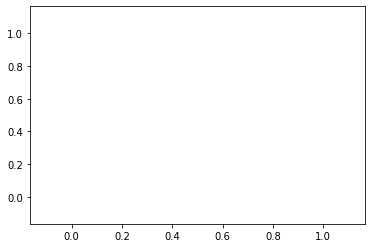

In [23]:
# identify words with high level of local clustering

for idx, G in enumerate(nx_graphs):
    
    d_clustering = nx.get_node_attributes(G, 'triangles')
    d_words = nx.get_node_attributes(G, 'word')
    
    # sort ascending
    top_nodes = [t[0] for t in sorted(d_clustering.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    scores = [t[1] for t in sorted(d_clustering.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    top_words = [d_words[i] for i in top_nodes]  # idxs -> words
    
    # print
    K = 100
    print(top_words[:K])
    print()
    
    plt.plot(scores)
    

['diabetic', 'syndrome', 'gi', 'cardiovascular', 'acute', 'trastuzumab', 'animal', 'chronic', 'ovarian', 'pathology', 'dysfunction', 'pneumonia', 'epithelial', 'porcine', 'carcinoma', 'hepatic', 'pancreatic', 'glioma', 'hiv', 'respiratory', 'orally', 'necrosis', 'disorders', 'pathological', 'fibrosis', 'symptoms', 'diabetes', 'tnf', 'therapies', 'injury', 'invasive', 'diseases', 'mucosa', 'infectious', 'pathogenesis', 'inflammation', 'intravenous', 'endothelial', 'mdr', 'liver', 'systemic', 'prevention', 'diarrhea', 'cytokines', 'immunological', 'impaired', 'interventions', 'cat', 'pain', 'tract', 'insulin', 'canine', 'pulmonary', 'gastrointestinal', 'subcutaneous', 'vaccines', 'immune', 'alp', 'multidrug', 'toxin', 'colon', 'fu', 'cancers', 'epidermal', 'personalized', 'death', 'antigens', 'human', 'fibroblast', 'nervous', 'clinic', 'kidney', 'options', 'neurodegenerative', 'renal', 'igg', 'viral', 'prognosis', 'lesions', 'mucosal', 'disease', 'protease', 'gastric', 'neonatal', 'phosp

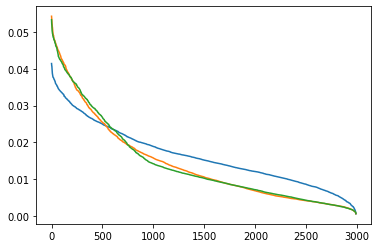

In [24]:
# identify words with high level of centrality
#    within the subgraph of most-common words

for idx, G in enumerate(nx_graphs):
    
    d_clustering = nx.get_node_attributes(G, 'eigenvector_centrality')
    d_words = nx.get_node_attributes(G, 'word')
    
    # sort ascending
    top_nodes = [t[0] for t in sorted(d_clustering.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    scores = [t[1] for t in sorted(d_clustering.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    
    top_words = [d_words[i] for i in top_nodes]  # idxs -> words
    
    # print
    K = 500
    print(top_words[:K])
    print()
    
    plt.plot(scores)

In [31]:
# generate a combined set of sample words

combined_words = set()

for idx, G in enumerate(nx_graphs):
    
    #d_clustering = nx.get_node_attributes(G, 'eigenvector_centrality')
    d_clustering = nx.get_node_attributes(G, 'eigenvector_centrality')
    d_words = nx.get_node_attributes(G, 'word')
    
    # sort ascending
    top_nodes = [t[0] for t in sorted(d_clustering.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    scores = [t[1] for t in sorted(d_clustering.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    
    top_words = [d_words[i] for i in top_nodes]  # idxs -> words
    
    # print
    K = 10
    
    combined_words = combined_words.union(set(top_words[:K]))
    
print(len(combined_words))


combined_nodes = []
for i,node in enumerate(G.nodes):
    if G.nodes[node]['word'] in combined_words:
        combined_nodes.append(node)

30


computing cuthill mckee ordering...
finished.
computing cuthill mckee ordering...
finished.
computing cuthill mckee ordering...
finished.


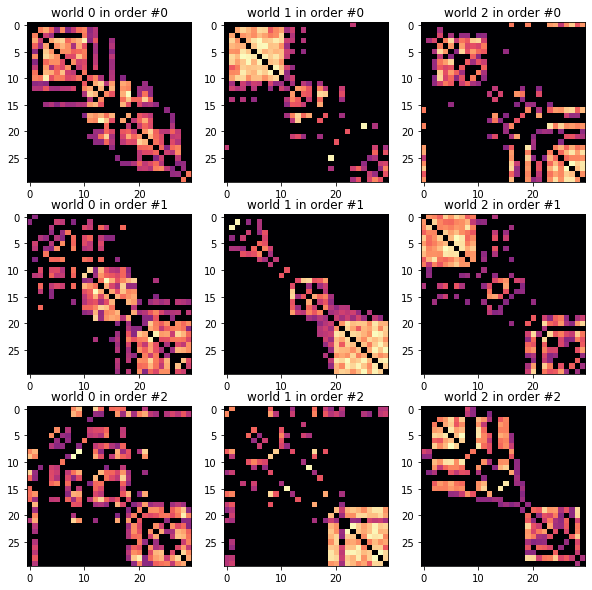

In [32]:
# compare the networks, zooming in on the combined_nodes subset

(f, ax) = plt.subplots(3,
                       3,
                       figsize=(10,10))

for reference_id in range(3):
    
    print('computing cuthill mckee ordering...')
    G = nx_graphs[reference_id].subgraph(combined_nodes)
    rcm = list(nx.utils.reverse_cuthill_mckee_ordering(G)) # pick the smallest to define the ordering
    print('finished.')


    for idx, G in enumerate(nx_graphs):
        #rcm = list(nx.utils.reverse_cuthill_mckee_ordering(G))
        W = nx.convert_matrix.to_numpy_matrix(G, nodelist=rcm)

        ax[reference_id,idx].imshow(W, aspect='auto', cmap='magma')
        ax[reference_id,idx].set_title('world {} in order #{}'.format(idx,reference_id))
plt.savefig('cuthill_mckee_subgraph.png')
plt.savefig('cuthill_mckee_subgraph.pdf')

In [33]:
# create a combined layout

W_total = np.zeros( (len(common_vocabulary), len(common_vocabulary)) )
for idx, G_ in enumerate(nx_graphs):
    
    W = nx.convert_matrix.to_numpy_matrix(G_)
    W_total += W
    
G_total = nx.from_numpy_matrix(W_total)
G_subgraph = G_total.subgraph(combined_nodes) # just the high-centrality union set
d_layout = nx.spring_layout(G_subgraph)

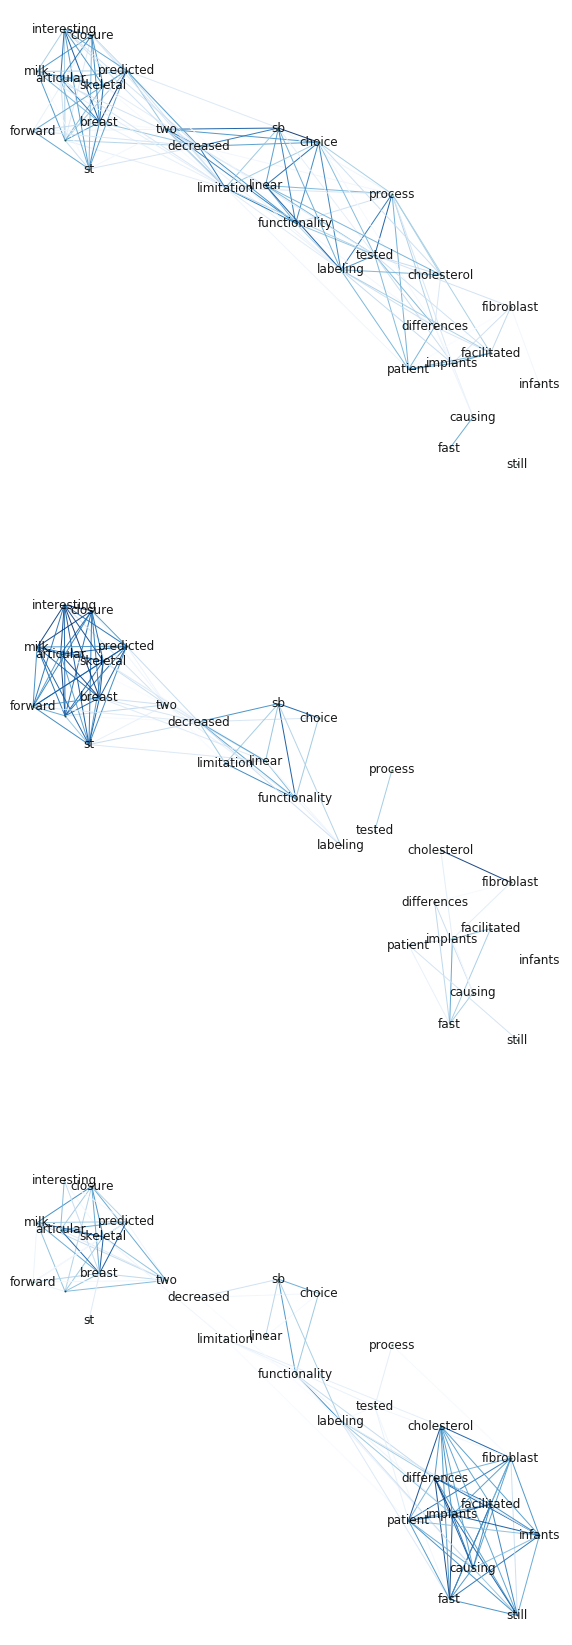

In [34]:
(f, ax) = plt.subplots(3,
                       1,
                       sharex='all', sharey='all',
                       figsize=(10,30))


for idx, G_ in enumerate(nx_graphs):
        
    G = G_.subgraph(combined_nodes)
        
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    #print(weights)
    
    labels = dict( (node,common_vocabulary[i]) for i,node in enumerate(G.nodes()))
    #print(labels)
    
    #doc_freq_ = dict( (node, doc_freqs[idx][labels[i]]) for i,node in enumerate(G.nodes()))
    #print(doc_freq)
    
    SCALE = 30000
    #node_sizes = SCALE*np.array([f for f in doc_freq_.values()])
    nx.draw(G,
           pos=d_layout, # s[idx],  #d_layout
           with_labels=True,
           node_color=[[0.1,0.3,0.2,0.1]],
           node_size=1, # node_sizes,
           labels=labels,
           ax=ax[idx],
           edgelist=edges,
           edge_color=weights,
           alpha=0.9,
           width=1.0,
           edge_cmap=plt.cm.Blues)    
    
    '''
    nx.draw_networkx_nodes(G,
           pos=d_layout,
           node_size=10,
           with_labels=True,
           color=[0,0.75, 0.25],
           alpha=0.75,
           ax=ax[idx])
    
    
    #weights = [G[e[0]][e[1]] for e in G.edges]
    nx.draw_networkx_edges(G,
                     pos=d_layout,
                     alpha=0.1,
                     ax=ax[idx],
                     edgelist=edges,
                     edge_colors=weights,
                     width=10.0,
                     edge_cmap=plt.cm.Spectral)
    '''

plt.savefig('word similarity nets 3 wlabels.pdf')
plt.savefig('word similarity nets 3 wlabels.png')


In [166]:
plt.close('all')

In [28]:
# test the punctuation stripping

test = ':hi-this - "low-hanging" is p=5.00, a less -5 looking number l5m'


# first sub numbers
test1 = re.sub(r'[+-]?[\d]+',' _NUM_ ', test) # '^[-+]?[\d]$","\n",p) #  substitute numbers
print(test1)

# then strip punctuation
test2 = re.sub(r'[^\w\s]',' ',test1)  # todo check this

print(test2)

str.split(test2)



:hi-this - "low-hanging" is p= _NUM_ . _NUM_ , a less  _NUM_  looking number l _NUM_ m
 hi this    low hanging  is p  _NUM_   _NUM_   a less  _NUM_  looking number l _NUM_ m


['hi',
 'this',
 'low',
 'hanging',
 'is',
 'p',
 '_NUM_',
 '_NUM_',
 'a',
 'less',
 '_NUM_',
 'looking',
 'number',
 'l',
 '_NUM_',
 'm']

In [9]:
# igraph plotting works but isn't interlacing with matplotlib (seems like a backend issue??)

# note - need cairo & cairo python bindings (cairocffi)
#   cairo itself - https://www.cairographics.org/download/

#for idx, G in enumerate(ggg.values()):
G = ggg[0]
print(idx)

print(type(G))
print(G.es[100])

layout = G.layout("kk")

vis_style = {'vertex_size':0.1,
         'vertex_color':[1,1,0],
         'layout':layout}

igraph.plot(G, **vis_style)



2
<class 'igraph.Graph'>
igraph.Edge(<igraph.Graph object at 0x7fcf52e22850>, 100, {'weight': 0.7828428957999377})


In [75]:
V = [v.index for v in G.vs]
E = [(e.source, e.target) for e in G.es]

F = igraph.Graph()
F.add_vertices(V)
F.add_edges(E)

F.simplify()
F.vs.select(_degree=0).delete() # throw away the nodes with no connections

print(F.vs[0])
print(F.es[0])

layout = F.layout_circle()

vis_style = {'vertex_size':1,
         'vertex_color':[1,1,0],
         'layout':layout}

igraph.plot(F, **vis_style).show()

igraph.Vertex(<igraph.Graph object at 0x7fb718bb4a50>, 0, {'name': 0})
igraph.Edge(<igraph.Graph object at 0x7fb718bb4a50>, 0, {})


In [43]:
#  https://stackoverflow.com/questions/22934342/no-image-from-plot-in-igraph-python

pl = igraph.Plot()
pl._repr_svg_()   # check if this works ( A: it works)
pl.add(G, layout=layout)
#pl._windows_hacks=True
pl.show()


In [39]:
# test community detection on the graph
dendrogram = ggg[0].community_fastgreedy()
clusters = dendrogram.as_clustering()
membership = clusters.membership

KeyboardInterrupt: 

In [46]:
# test local triangle clustering
triangle_scores = ggg[0].transitivity_local_undirected(weights='weight')
print(np.shape(triangle_scores))

(2792,)


In [190]:
# plotting works - it's just this particular
'''
G = igraph.Graph.Full(3)
layout = G.layout("kamada_kawai")
vis_style = {'vertex_size':0.5,
             'vertex_color':[1,1,0],
             'layout':layout}

igraph.plot(G, **vis_style)
'''

'\nG = igraph.Graph.Full(3)\nlayout = G.layout("kamada_kawai")\nvis_style = {\'vertex_size\':0.5,\n             \'vertex_color\':[1,1,0],\n             \'layout\':layout}\n\nigraph.plot(G, **vis_style)\n'

In [8]:
# plot common network (look for different neighborhood patterns)

array([[False,  True, False, ...,  True,  True, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False,  True]])

(9500, 9500)
(10622, 10622)
(4977, 4977)


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

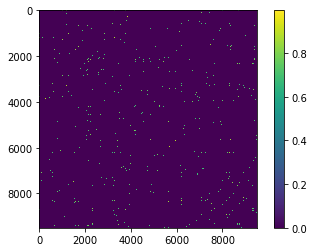

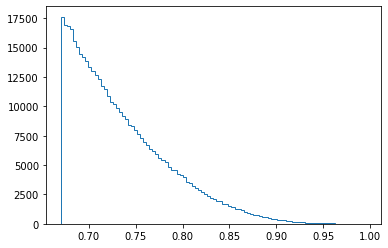

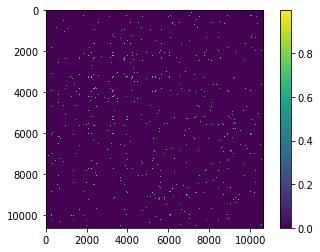

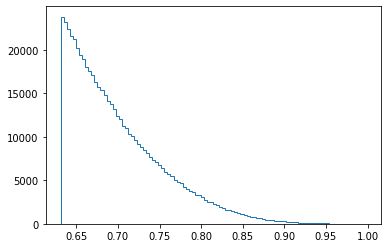

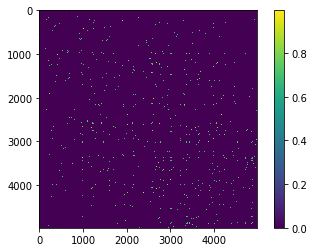

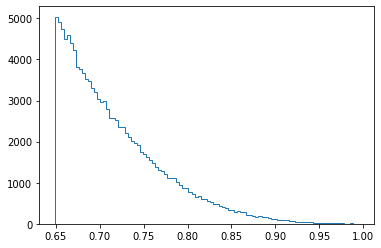

In [24]:
# plot full network for each cluster

# compare range to range of shared subnetwork

# todo match vocabulary sizes


nx_graphs = []
for idx, model in enumerate(models.values()):
    
    # the number of nodes is small so we can do this with mat mul
    D = np.shape(model.wv[common_vocabulary[0]])[0]
    
    embedding_samples = np.zeros( (len(model.wv.vocab), D) )
    
    # collect samples
    for i_word, word in enumerate(model.wv.vocab):
        embedding_samples[i_word,:] = model.wv[word]
        
    # reduce dimensionality
    #D_umap = 5
    #reducer = umap.UMAP(n_components=D_umap)
    #um = reducer.fit_transform(embedding_samples)    # concatenated
    #embedding_samples = um
    
    # demean
    for i_word, word in enumerate(model.wv.vocab):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
    
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
        
    # compute cosine similarity (projection of normalized vectors)
    W = np.matmul(embedding_samples, embedding_samples.T)
    np.fill_diagonal(W, 0)  # no self-loops
    thresh_low = np.percentile(W.flatten(), 1)
    thresh_high = np.percentile(W.flatten(), 99)
    #boolean_mask = np.logical_and(W < thresh_high, W > thresh_low)
    boolean_mask = W < thresh_high
    W[boolean_mask] = 0 # mask out some weights for testing
    print(np.shape(W))
    
    plt.figure()
    plt.imshow(W)
    plt.colorbar()
    
    plt.figure()
    plt.hist(np.tril(W,k=-1)[np.tril(W,k=-1).nonzero()].flatten(),histtype='step', bins=100)
    
    #W_binary = (W > 0).tolist()
    #ggg[idx] = igraph.Graph.Adjacency(W_binary)  # define connections
    #ggg[idx].es['weight'] = W[W.nonzero()]
    #G_igraph = igraph.Graph.Weighted_Adjacency(W.tolist(),
    #                                           mode=igraph.ADJ_UNDIRECTED,
    #                                          loops=False,
    #                                          attr='weight')
    #igraphs.append(G_igraph)
    
    # create networkx version
    G_nx = nx.from_numpy_matrix(W)  # create using - 
    nx.set_node_attributes(G_nx,
                           dict((i,w) for i,w in enumerate(model.wv.vocab)),
                           'word')
    d_eigcent = nx.eigenvector_centrality(G_nx)
    nx.set_node_attributes(G_nx, d_eigcent, 'eigenvector_centrality')
    nx_graphs.append(G_nx)
    

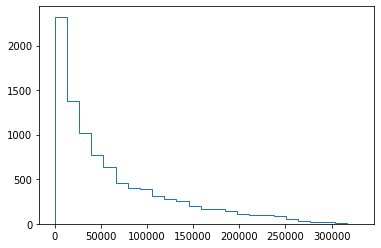

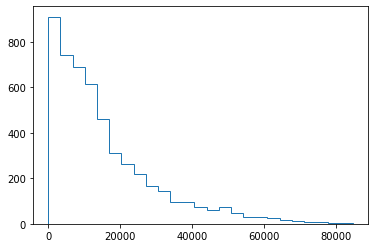

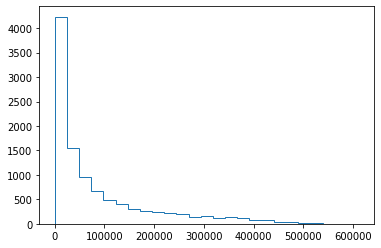

In [250]:
# get triplet clustering for each world

for idx, G in enumerate(nx_graphs):
    d_triangles = nx.triangles(G)

    plt.figure()
    plt.hist([v for v in d_triangles.values()], bins=25, histtype='step')
    

# aggregate using maximum

# plot to compare
 


['canada', 'southeast', 'australian', 'usa', 'africa', 'indian', 'peninsula', 'southwestern', 'caribbean', 'french', 'asian', 'california', 'southern', 'europe', 'australia', 'florida', 'rocky', 'salmon', 'carnivores', 'portugal', 'eastern', 'east', 'american', 'plantations', 'west', 'mexico', 'arid', 'mediterranean', 'turtle', 'north', 'bird', 'america', 'mountain', 'southwest', 'beaches', 'northern', 'lowland', 'african', 'south', 'spain', 'asia', 'endemic', 'italy', 'argentina', 'fishes', 'northeastern', 'bats', 'coast', 'county', 'indonesia', 'continental', 'poland', 'korea', 'mountains', 'atlantic', 'park', 'brazilian', 'elsewhere', 'northwest', 'northwestern', 'crab', 'republic', 'fauna', 'mite', 'subtropical', 'france', 'georgia', 'annually', 'semiarid', 'snail', 'desert', 'country', 'tropical', 'hemiptera', 'gulf', 'japan', 'domestic', 'reefs', 'diptera', 'india', 'temperate', 'northeast', 'estuary', 'malaysia', 'pacific', 'brazil', 'island', 'acari', 'imported', 'localities', 

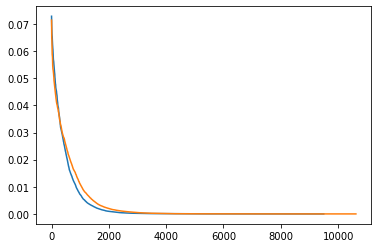

In [25]:
# identify words with high level of centrality

for idx, G in enumerate(nx_graphs):
    
    d_clustering = nx.get_node_attributes(G, 'eigenvector_centrality')
    d_words = nx.get_node_attributes(G, 'word')
    
    # sort ascending
    top_nodes = [t[0] for t in sorted(d_clustering.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    scores = [t[1] for t in sorted(d_clustering.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    
    top_words = [d_words[i] for i in top_nodes]  # idxs -> words
    
    # print
    K = 500
    print(top_words[:K])
    print()
    
    plt.plot(scores)

In [42]:
# check the first order differences and commonalities
import math

word_counts = []
word_totals = []
word_freqs = []
for idx, model in enumerate(models.values()):
    print(model)
    word_count = {}
    total = 0
    
    for word in model.wv.vocab:
        count = model.wv.vocab[word].count
        word_count[word] = count
        total += count
        
    word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))
    
    word_freq = {}
    for i_word, word in enumerate(word_count.keys()):
        freq = word_count[word] / total
        log_freq = math.log(freq)
        word_freq[word] = log_freq
        
    print(word_freq)
        
    word_counts.append(word_count)
    word_freqs.append(word_freq)
    word_totals.append(word_totals)     
    
# show top words and unique words



Word2Vec(vocab=9425, size=25, alpha=0.025)
{'the': -2.7528048309508373, 'of': -3.0226046788400915, 'and': -3.2104479282845566, 'in': -3.619218156110931, 'to': -3.8386907801341277, 'a': -3.9490291360059295, '<NUM>': -4.211508779244992, 'for': -4.37450131219637, 'with': -4.5713305424625545, '': -4.5928446459122085, 'is': -4.757954538375816, 'that': -4.834400496543747, 'by': -4.888082673288492, 'on': -4.958049694253735, 'was': -4.991911286319355, 'as': -5.000152073696165, 'were': -5.038921027070134, 'from': -5.126174060859953, 'this': -5.176014132665379, 'we': -5.238802717040775, 'are': -5.288903938570725, 'an': -5.481178060025257, 'be': -5.58966026979, 'at': -5.628545749953217, 'using': -5.807057579518426, 'which': -5.815111595127498, 'study': -5.935615720898243, 'these': -5.974263206599551, 'can': -5.974386351726239, 'have': -6.076604573658376, 'results': -6.086749985603825, 'or': -6.156067719396317, 'their': -6.163033290353456, 'species': -6.166012142720043, 'analysis': -6.213825755231

In [28]:
# compare the log frequency tails for the 3 models
'''
plt.figure()

for idx, model in enumerate(models.values()):
    
    yy = [x for x in word_freqs[idx].values()]
    plt.plot(yy)
'''

'\nplt.figure()\n\nfor idx, model in enumerate(models.values()):\n    \n    yy = [x for x in word_freqs[idx].values()]\n    plt.plot(yy)\n'

data_processing/testmodel_cluster0_corpus.json
{'on': 0.6334762953518025, 'we': 0.4987249333487887, 'has': 0.2663730149530544, 'method': 0.18355164019937406, 'therefore': 0.07609829604729339, 'moreover': 0.0684478961400255, 'determined': 0.059986090181986786, 'dna': 0.05059696302306711, 'stable': 0.04909006607163556, 'affected': 0.03454271473281558, 'resolution': 0.03071751477918164, 'optimized': 0.02857308450214443, 'toward': 0.028515126927089372, 'little': 0.0268923148255477, 'validated': 0.025385417874116148, 'testing': 0.02480584212356555, 'article': 0.024747884548510492, 'independent': 0.021328387620261968, 'generate': 0.02080676944476643, 'explored': 0.02051698156949113, 'attributed': 0.020343108844325955, 'classification': 0.01669178161585719, 'complexity': 0.015938333140141415, 'threedimensional': 0.01564854526486612, 'infected': 0.015416714964645879, 'correlations': 0.01153355743595688, 'mm': 0.010548278660020866, 'depend': 0.00967891503419497, 'complicated': 0.007882230207488

In [ ]:
# todo subselect words from the full_vocabulary with high local clustering